Product Owner have to choose between two KPIs of his product and invest money in one of possible directions. For example - traffic attraction or conversion optimization. These are two strategies and his backlog have to be prioritized right now. Here we use ML scores as a measure of KPI selection. In fact we look how this or that KPI helps to predict possible cash flow. In this example we have one product with fixed price. We use web metrics to understand what strategy should be chosen - attraction or activation, Ads  or CRO. I show that standard statistical measures like correlation fail and nonlinear ML models give insight. It works on relatively small data (1092 records) - natural limitation. That's why ensemble voting, binning of target and dimension reduction are involved to avoid overfit. I explore two groups of metrics. First (I) corresponds to conversion - bounce rate, depth of view, conversion to contact page, time of session. Second (II) corresponds to traffic (ads channel is a major factor for this product): number of sessions, number uniqie new visitors, number of views. I use the daily discretization of web and crm data. The target function is a number of commercial offers/day. Input features correspond to the New Visitors segment (!). Segmentation is done, using Google Analytics and Yandex Metrics APIs. 

In [418]:
from __future__ import division
import warnings
warnings.filterwarnings("ignore")

Define general parameters

In [419]:
split_num=10 #number of cross validation intervals
out_sample=0.5 #out-of-sample split
neigbors_maximum=10 #max number of neighbors for KNN

Import general libraries: arrays,dateframe

In [420]:
import numpy as np #work with arrays
import pandas as pd #work with dateframe
from pandas import set_option
import matplotlib.pyplot as plt #work with charts
import seaborn as sns #work with color charts
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid #work with charts
from numpy import linspace, loadtxt, ones, convolve

Import statistical libraries

In [421]:
from scipy.stats.stats import pearsonr #correlation method
from statistics import median #median search

Import ML libraries for out-of-sample tests and hyperparameter tuning

In [422]:
from sklearn.model_selection import train_test_split #standard out-of-sample test
from sklearn.model_selection import cross_val_score #cross validation test
from sklearn.model_selection import GridSearchCV #hyperperameter tuning
from sklearn.model_selection import KFold #sample split

Import ML libraries

In [423]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier

In [424]:
def standart(x):
    max_value=x.max();
    min_value=x.min()
    z=(x-min_value) / (max_value - min_value)
    return z

Custom functions - correlation map

In [425]:
def cormap(x):
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()

Custom functions - Person coefficient output

In [426]:
def cf(x,y):
  CFV=pearsonr(x,y);correlation=str(abs(round(int(100*CFV[0]))))
  p_mystake=str(round((100*CFV[1]),3));cf_mst=[correlation,p_mystake]
  return cf_mst

Custom functions - exploratory analysis

In [427]:
def eda(x):
  pd.plotting.scatter_matrix(x,figsize=[8,8],diagonal='kde',grid=True,ax=None,range_padding=1)
  plt.show()

Classification of continuous var by median

In [428]:
def get_class(x):
  threshold=median(list(x))
  #threshold=0.5
  class_type=[]
  for item in list(x):
    if item>=threshold: label=1;class_type.append(label)
    if item<threshold: label=0;class_type.append(label)
  return class_type  

Custom functions - plot PCA components and moving average

In [429]:
def pca(x,y):
  pca=PCA()
  pca.fit(y) 
  PCA(copy=True)
  features=x
  pca.explained_variance_=standart(pca.explained_variance_)
  pca.explained_variance_=list(np.array(pca.explained_variance_)*100)
  plt.bar(x, pca.explained_variance_,width=0.5)
  plt.xticks(features);plt.ylabel('variance');plt.xlabel('PCA feature')
  print('Input of component - PCA:')
  for i in range(0,len(pca.explained_variance_)):
    print(str(x[i])+': '+str(int(pca.explained_variance_[i]))+'%')
    i=i+1
  plt.show()

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Read data from 3 xls files and merge data from crm and Web Analytics platform. 3 years of daily records. We make an output of first 5 records

In [430]:
df_all=pd.read_excel('all_pages.xlsx')

df_contacts=pd.read_excel('contacts.xlsx')
df_all_contacts=df_all.merge(df_contacts,how='left',left_on='Date',right_on='Date')
df_all_contacts['Visits_contacts']=df_all_contacts['Visits_contacts'].fillna(0)

df=df_all_contacts.merge(df_crm,how='left',left_on='Date',right_on='Date');df['Offers']=df['Offers'].fillna(0)
df['Conversion']=100*df['Visits_contacts']/df['Visits']
del df['Visits_contacts']

Show column names

In [431]:
column_names=list(df.columns.values)
print('All fields:',column_names)

All fields: ['Date', 'Visits', 'Viewers', 'Views', 'BR', 'Depth', 'Time', 'Offers', 'Conversion']


Show time interval:

In [432]:
print('Data Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])

Data Start: 2016-05-09 00:00:00
Data End: 2019-05-07 00:00:00


Show number of records - small data

In [433]:
print('Number of records:', len(df))

Number of records: 1092


Compres features to (0,1) to avoid ML unstability

In [434]:
df['Visits']=standart(df['Visits']);df['Viewers']=standart(df['Viewers'])
df['Views']=standart(df['Views']);df['BR']=standart(df['BR'])
df['Depth']=standart(df['Depth']);df['Time']=standart(df['Time'])
df['Offers']=standart(df['Offers']);df['Conversion']=standart(df['Conversion'])

Remove date feature

In [435]:
del df['Date']

Make correlation map

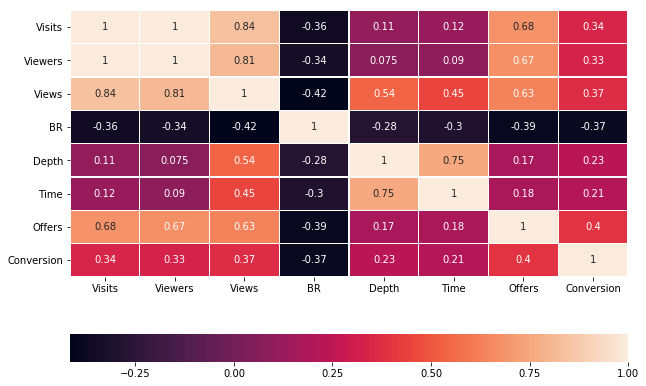

In [436]:
cormap(df)

We can see that Offers are correlated mostly with Visits/Viewers/Views - traffic. Small correlation with conversion features like Bounce Rate and Conversion into "Contacts" page. Ok, let's analyze feature input by PCA.

Input of component - PCA:
Visits: 100%
Viewers: 35%
Views: 15%
BR: 10%
Depth: 2%
Time: 0%
Conversion: 0%


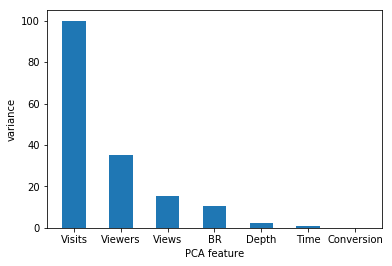

In [437]:
df_pca=df.copy()
del df_pca['Offers']
column_names=df_pca.columns
pca(column_names,df_pca)

Number of sessions is in top. Other metrcis have less significance and are naturally ordered. We get EDA for Offers distribution. 

In [438]:
set_option('display.width',100)
set_option('precision',3)

print('Offers:')
description=df['Offers'].describe()
print(description)

Offers:
count    1092.000
mean        0.221
std         0.194
min         0.000
25%         0.000
50%         0.231
75%         0.346
max         1.000
Name: Offers, dtype: float64


We may split target variable Offers into 2 classes by median threshold. We prepare data for binary classificators. Let's detect percent of positive offers per day first.

In [439]:
offers_positive=len(df[df['Offers']>0])
general_length=len(df)
print('Number of days with [offers>0] number is '+str(round(100*offers_positive/general_length))+'%')

Number of days with [offers>0] number is 70%


In [440]:
df_binary=df.copy()
df_binary['Offers binary']=get_class(df_binary['Offers'])
del df_binary['Offers']

Let's split 5 features from target.

In [441]:
array_df_binary=df_binary.values
X=array_df_binary[:,0:7];Y=array_df_binary[:,7]

Estimation of feature importance based on tree classifier. 

In [442]:
model=ExtraTreesClassifier(n_estimators=100)
model.fit(X, Y)
print('Importance of Visits,Viewers,Views,BR,Depth,Time,Conversion by tree classificator:\n')

tree_features=['Visits','Viewers','Views','BR','Depth','Time,Conversion']
imp=list(model.feature_importances_)
df_tree_importance=pd.DataFrame({'Visits':[imp[0]],'Viewers':[imp[1]],'Views':[imp[2]],'BR':[imp[3]],'Depth':[imp[4]],
                                 'Time':[imp[5]],'Conversion':[imp[6]]},
                                columns=['Visits','Viewers','Views','BR','Depth','Time','Conversion'])

print(df_tree_importance.head())

Importance of Visits,Viewers,Views,BR,Depth,Time,Conversion by tree classificator:

   Visits  Viewers  Views   BR  Depth   Time  Conversion
0   0.213     0.22  0.163  0.1  0.094  0.087       0.122


We can see that both conversion and traffic metrics influences the target but the traffic influence is higher. Construct arrays for fetures and target of regression models. Let's firstly involve all features.

In [443]:
df_reg=df.copy()
new_order=[0,1,2,3,4,5,7,6]
df_reg[df.columns[new_order]]
#del df_reg['Viewers'];del df_reg['Depth'];del df_reg['Time'] 
print(df_reg.head())

array_reg=df_reg.values
X_reg=array_reg[:,0:7];Y_reg=array_reg[:,7]

   Visits  Viewers  Views     BR  Depth   Time  Offers  Conversion
0   0.054    0.051  0.028  0.234  0.054  0.022   0.038       0.364
1   0.288    0.267  0.199  0.333  0.095  0.209   0.000       0.296
2   0.304    0.261  0.385  0.226  0.234  0.346   0.231       0.421
3   0.293    0.267  0.204  0.468  0.096  0.143   0.346       0.145
4   0.223    0.233  0.115  0.459  0.053  0.084   0.115       0.381


Try regression models. Let's do ensemble prediction by stacking technique 

In [444]:
kfold=KFold(n_splits=split_num, random_state=7)
ridge=Ridge(alpha=1,fit_intercept=True)
knn=KNeighborsRegressor()
svr=SVR(gamma='auto')

stregr=StackingRegressor(regressors=[ridge,knn,svr], meta_regressor=ridge)
results=cross_val_score(stregr, X_reg, Y_reg, cv=kfold, scoring='r2')
print('Mean R2 for stacking Regression:',round(results.mean(),2))
print('Deviation for stacking Regression:',round(results.std(),2))

Mean R2 for stacking Regression: 0.07
Deviation for stacking Regression: 0.2


Low significance. Let's try traffic features.

In [445]:
df_reg=df.copy()
new_order=[0,1,2,3,4,5,7,6]
df_reg[df.columns[new_order]]
del df_reg['BR'];del df_reg['Depth'];del df_reg['Time'];del df_reg['Conversion']  
print(df_reg.head());print('\n')

array_reg=df_reg.values
X_reg=array_reg[:,0:3];Y_reg=array_reg[:,3]

kfold=KFold(n_splits=split_num, random_state=7)
ridge=Ridge(alpha=1,fit_intercept=True)
knn=KNeighborsRegressor()
svr=SVR(gamma='auto')

stregr=StackingRegressor(regressors=[ridge,knn,svr], meta_regressor=ridge)
results=cross_val_score(stregr, X_reg, Y_reg, cv=kfold, scoring='r2')
print('Mean R2 for stacking Regression:',round(results.mean(),2))
print('Deviation for stacking Regression:',round(results.std(),2))

   Visits  Viewers  Views  Offers
0   0.054    0.051  0.028   0.038
1   0.288    0.267  0.199   0.000
2   0.304    0.261  0.385   0.231
3   0.293    0.267  0.204   0.346
4   0.223    0.233  0.115   0.115


Mean R2 for stacking Regression: 0.5
Deviation for stacking Regression: 0.06


The result is better. Let's try seperately most obvious conversion features.

In [446]:
df_reg=df.copy()
new_order=[0,1,2,3,4,5,7,6]
df_reg[df.columns[new_order]]
del df_reg['Visits'];del df_reg['Viewers'];del df_reg['Views'];del df_reg['Time'];del df_reg['Depth']
print(df_reg.head());print('\n')

array_reg=df_reg.values
X_reg=array_reg[:,0:2];Y_reg=array_reg[:,2]

kfold=KFold(n_splits=split_num, random_state=7)
ridge=Ridge(alpha=1,fit_intercept=True)
knn=KNeighborsRegressor()
svr=SVR(gamma='auto')

stregr=StackingRegressor(regressors=[ridge,knn,svr], meta_regressor=ridge)
results=cross_val_score(stregr, X_reg, Y_reg, cv=kfold, scoring='r2')
print('Mean R2 for stacking Regression:',round(results.mean(),2))
print('Deviation for stacking Regression:',round(results.std(),2))

      BR  Offers  Conversion
0  0.234   0.038       0.364
1  0.333   0.000       0.296
2  0.226   0.231       0.421
3  0.468   0.346       0.145
4  0.459   0.115       0.381


Mean R2 for stacking Regression: 0.07
Deviation for stacking Regression: 0.17


OK. Regression gives poor results - it's not surprise for small and noisy data. However we may notice that traffic has a greater influence. Let's move to classifiers with binned target. Let's make an ensemble of classificators for binary table. First - we use all features.

In [447]:
estimators = []
a=KNeighborsClassifier(n_neighbors=neigbors_maximum)
b=GaussianNB()
c=DecisionTreeClassifier(criterion='entropy')

estimators.append(('knn',a))
estimators.append(('naive', b))
estimators.append(('dt', c))

ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X, Y, cv=kfold)
print('Average score of validation for ensamble:'+str(round(100*results.mean()))+'%')
print('Deviation of validation score:'+str(round(100*results.std()))+'%')

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=out_sample)
model=ensemble;model.fit(X_train,Y_train)
score_nb=model.score(X_test, Y_test)
print('Accuracy for the out-of-sample 50/50 test='+str(100*round((score_nb),1))+'%')

Average score of validation for ensamble:81.0%
Deviation of validation score:7.0%
Accuracy for the out-of-sample 50/50 test=80.0%


Great! What if we remove consequently remove features according to PCA/TreeClassificator results? We look at the accuracy. Let's use the traffic features seperately. Several combination of three features show the best results for session only. It is quite reasonable as Views and User number correlates with number of sessions. So reduction of dumensionality has to improve result.

In [448]:
X=array_df_binary[:,0:1]
estimators = []
a=KNeighborsClassifier(n_neighbors=neigbors_maximum)
b=GaussianNB()
c=DecisionTreeClassifier(criterion='entropy')

estimators.append(('knn',a))
estimators.append(('naive', b))
estimators.append(('dt', c))

ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X, Y, cv=kfold)
print('Average score of validation for ensamble:'+str(round(100*results.mean()))+'%')
print('Deviation of validation score:'+str(round(100*results.std()))+'%')

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=out_sample)
model=ensemble;model.fit(X_train,Y_train)
score_nb=model.score(X_test, Y_test)
print('Accuracy for the out-of-sample 50/50 test='+str(100*round((score_nb),1))+'%')

Average score of validation for ensamble:81.0%
Deviation of validation score:6.0%
Accuracy for the out-of-sample 50/50 test=80.0%


Less features - less overfit risk. So, finally we have traffic as a most powerful KPI, which predicts binary function of offers number with accuracy of about 80%. However not accuracy, but factor analysis is essential. PCA, EDA, Tree Classifier show that traffic features determine conversion into the commercial offer. PO may focus on traffic attraction more than web CRO. Let's insert moving averages with window of Q1 for sessions,BR and offers to verify the result.   

In [449]:
df_origin=df.copy()
df_origin['Visits-s']=standart(df_origin['Visits'])
df_origin['Offers-s']=standart(df_origin['Offers'])
df_origin['BR-s']=standart(df_origin['BR'])
df_origin['Conversion-s']=standart(df_origin['Conversion'])

Sessions=list(df_origin['Visits-s'])
Offers=list(df_origin['Offers-s'])
BR=list(df_origin['BR-s'])
Contact_CR=list(df_origin['Conversion-s'])

x=range(len(Sessions))
y_av_ses=list(movingaverage(Sessions,60))
y_av_offers=list(movingaverage(Offers,60))
y_av_br=list(movingaverage(BR,60))
y_av_cr=list(movingaverage(Contact_CR,60))

Look at the Offers vice Session

<Figure size 432x288 with 0 Axes>

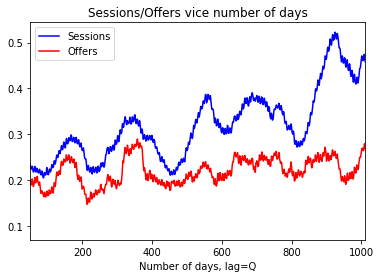

<Figure size 432x288 with 0 Axes>

In [453]:
plt.plot(x, y_av_ses,'b')
plt.plot(x, y_av_offers,'r')
plt.title('Sessions/Offers vice number of days')
plt.xlabel('Number of days, lag=Q')
plt.xlim(right=1010,left=50)
plt.gca().legend(('Sessions','Offers'))
plt.figure()

Good correlation, but the gap between traffic and Offers is growing - we have to work on the quality of audience. Let's create the correlation matrix of movings.

In [454]:
d={'Sessions':y_av_ses,'Offers':y_av_offers,'Bounce rate':y_av_br,'Conversion rate':y_av_cr}
df_movings=pd.DataFrame(d)
print(df_movings.corr())

                 Sessions  Offers  Bounce rate  Conversion rate
Sessions            1.000   0.703        0.138           -0.085
Offers              0.703   1.000        0.118            0.106
Bounce rate         0.138   0.118        1.000           -0.006
Conversion rate    -0.085   0.106       -0.006            1.000


The conclusions of ML are verified. We see that traffic attraction may give 20/80 effect. CRO corresponds to 10% of total effect. However the gap is growing - so the attracted audience relevence is falling. So the marketing department should work on the attraction of target audience by Ads. Thank you for your attention. 